In [1]:
%matplotlib inline
import h5py
import pandas as pd
from sklearn import manifold

from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
sns.set()

random_seed = 42

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,xgboost,tpot -g

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
pandas 0.22.0
xgboost 0.7
tpot 0.9.2

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 48
interpreter: 64bit
Git hash   : 5da2a53dd14d4c2c411e0586f87182e4240934a6


In [3]:
bad = (pd.read_hdf('ISMS_PALM_data_dump.h5', 'fid_data')
       .assign(good=0)
       .sample(n=300000, random_state=random_seed))
       
good = (pd.read_hdf('ISMS_PALM_data_dump.h5', 'good_data')
        .assign(good=1)
        .sample(n=300000, random_state=random_seed))

df = pd.concat([bad, good]).sample(frac=1.0)  # put them together and then shuffle

feature_cols = ['nphotons', 'sigma_x', 'sigma_y', 'sigma_z', 'offset', 'amp', 'chi2']
X = df.loc[:, feature_cols]
y = df.good

In [4]:
X.head(10)

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
10171664,599.0,0.084915,0.116051,77.363274,32.910500,61.489372,160.547760
2282420,4230.0,0.036085,0.026316,31.486397,62.446556,363.757782,1283.379639
5895232,762.0,0.085784,0.073886,67.914406,33.978451,79.084106,152.731842
13677383,10122.0,0.012575,0.016207,10.149652,49.672535,1068.892944,818.619202
8607277,626.0,0.076350,0.117744,77.186867,30.704117,61.740345,198.985779
13103212,706.0,0.080225,0.082804,65.455002,33.032013,76.149361,228.181595
11867560,578.0,0.080500,0.124981,79.733849,27.434507,55.851589,234.121964
12767266,550.0,0.094108,0.099086,77.454643,28.296879,59.577602,193.280136
10191171,7948.0,0.014178,0.026703,17.339472,42.142021,657.659546,758.617981
6372381,12671.0,0.011474,0.013651,8.856322,55.088314,1360.998535,939.292847


Summary stats

In [5]:
X.describe()

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,5230.885438,0.054990,0.065291,51.791564,46.584478,502.148625,566.552945
std,7676.040465,0.036977,0.043759,35.367183,19.822368,743.828376,596.173199
min,500.000000,0.003493,0.003852,2.955715,0.006650,50.000080,83.454880
25%,664.000000,0.014367,0.019590,13.248857,31.906822,65.480406,203.879444
50%,1125.000000,0.060857,0.066356,55.316990,43.821569,110.677330,356.539169
75%,8833.000000,0.083618,0.099500,78.232935,53.791242,852.451401,743.720383
max,114269.000000,0.249763,0.248705,246.504898,511.695892,12033.718750,10297.985352


Correlation

In [6]:
X.corr()

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
nphotons,1.000000,-0.675072,-0.654934,-0.659092,0.677235,0.987815,0.899265
sigma_x,-0.675072,1.000000,0.841006,0.949682,-0.386932,-0.667188,-0.571736
sigma_y,-0.654934,0.841006,1.000000,0.904465,-0.401427,-0.655001,-0.579353
sigma_z,-0.659092,0.949682,0.904465,1.000000,-0.348163,-0.660407,-0.548419
offset,0.677235,-0.386932,-0.401427,-0.348163,1.000000,0.665127,0.765688
amp,0.987815,-0.667188,-0.655001,-0.660407,0.665127,1.000000,0.870322
chi2,0.899265,-0.571736,-0.579353,-0.548419,0.765688,0.870322,1.000000


Counts of good vs. bad

In [7]:
y.value_counts()

1    300000
0    300000
Name: good, dtype: int64

Check no missing values

In [8]:
assert X.isnull().values.ravel().sum() == 0

### Visualize

In [9]:
%%time

n_components = 2
tsne_sample_size = 5000
xx = X.head(tsne_sample_size)
# shouldn't this also be y.head(tsne_sample_size)???
yy = y[:tsne_sample_size]
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0,)
zz = tsne.fit_transform(xx)

Wall time: 9min 32s


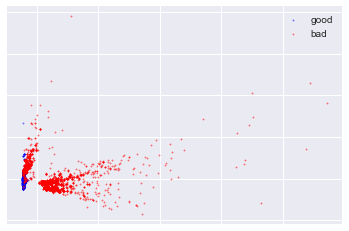

In [10]:
fig, ax = plt.subplots()
ax.scatter(zz[yy == 1, 0], zz[yy == 1, 1], s=2, c='b', alpha=0.5, label='good')
ax.scatter(zz[yy == 0, 0], zz[yy == 0, 1], s=2, c='r', alpha=0.5, label='bad')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter()) 
plt.legend()
plt.show()

### Models

Train/test split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [12]:
X_train.shape, y_train.shape

((480000, 7), (480000,))

In [13]:
X_test.shape, y_test.shape

((120000, 7), (120000,))

In [14]:
from sklearn.metrics import *
from sklearn.metrics.classification import *

def evaluate_preds(y_hat):
    return pd.Series({
        'precision': precision_score(y_test, y_hat),
        'recall': recall_score(y_test, y_hat),
        'f1': f1_score(y_test, y_hat),
        'accuracy': accuracy_score(y_test, y_hat),
        'roc_auc': roc_auc_score(y_test, y_hat)
    })

def evaluate(clf):
    y_hat = %time clf.predict(X_test)
    return evaluate_preds(y_hat)

def feature_importances(clf):
    pd.Series(dict(zip(X.columns, clf.feature_importances_))).sort_index().plot.bar()
    plt.show()

#### K Nearest Neighbors

In [15]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

Wall time: 3.92 s


In [16]:
evaluate(knn)

Wall time: 6.31 s


accuracy     0.983700
f1           0.983695
precision    0.980231
recall       0.987184
roc_auc      0.983713
dtype: float64

In [17]:
%time knn_bad = knn.predict(bad[feature_cols])
%time knn_good = knn.predict(good[feature_cols])

Wall time: 15.5 s
Wall time: 26.2 s


#### Random forest

In [18]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

Wall time: 36.5 s


In [19]:
evaluate(rf)

Wall time: 379 ms


accuracy     0.986433
f1           0.986422
precision    0.983501
recall       0.989359
roc_auc      0.986445
dtype: float64

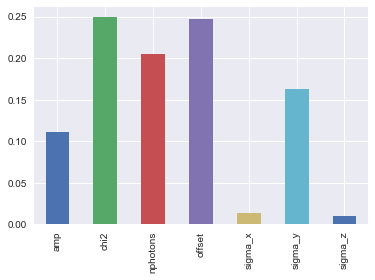

In [20]:
feature_importances(rf)

### Naive Bayes

In [21]:
%%time
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

Wall time: 399 ms


In [22]:
evaluate(nb)

Wall time: 89 ms


accuracy     0.959492
f1           0.959944
precision    0.945798
recall       0.974519
roc_auc      0.959549
dtype: float64

### XGBoost

In [23]:
%%time
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=5, n_estimators=100, nthread=16)
xgb.fit(X_train, y_train)

Wall time: 29.7 s


In [24]:
evaluate(xgb)

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Wall time: 649 ms


accuracy     0.986392
f1           0.986412
precision    0.981195
recall       0.991685
roc_auc      0.986412
dtype: float64

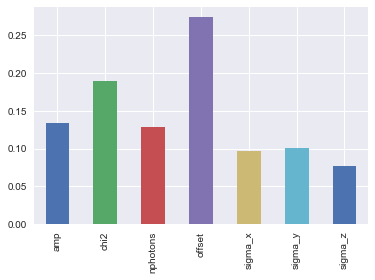

In [25]:
feature_importances(xgb)

#### Logistic regression

(This does amazingly well for a fast-to-train linear model.)

In [26]:
%%time
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(n_jobs=16)
lr.fit(X_train, y_train)

Wall time: 15.1 s


In [27]:
evaluate(lr)

Wall time: 6 ms


accuracy     0.973175
f1           0.973318
precision    0.964500
recall       0.982299
roc_auc      0.973210
dtype: float64

#### Big guns: TPOT

In [28]:
from tpot import TPOTClassifier

tp = TPOTClassifier(generations=5, max_time_mins=150, population_size=50, n_jobs=24, verbosity=2)
tp.fit(X_train, y_train)

306.49047171666666 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.



Best pipeline: ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=19, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=1000000, max_eval_time_mins=5,
        max_time_mins=150, memory=None, mutation_rate=0.9, n_jobs=24,
        offspring_size=50, periodic_checkpoint_folder=None,
        population_size=50, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

Turns out TPOT ended up with just a XGBoost classifier with a Robust Scaler for the inputs before they go in.

In [29]:
tp.export('tpot_pipeline_dph.py')

True

In [ ]:
# %load tpot_pipeline_dph.py
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.builtins import ZeroCount

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=42)

# Score on the training set was:0.9860291666666667
exported_pipeline = make_pipeline(
    ZeroCount(),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=19, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [30]:
evaluate(tp)

Wall time: 2.71 s


accuracy     0.986508
f1           0.986558
precision    0.979201
recall       0.994027
roc_auc      0.986537
dtype: float64

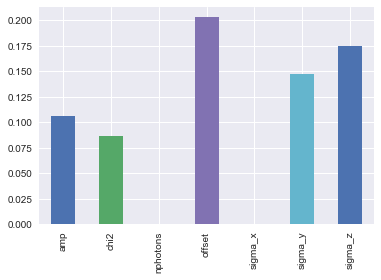

In [31]:
feature_importances(tp.fitted_pipeline_.steps[-1][1])

<hr>

## Voting classifier (ensemble of above)

In [32]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('rf', rf),
    ('lr', lr),
    ('knn', knn),
    ('nb', nb),
    ('xgb', tp),
]

predictions = (pd.DataFrame({name: model.predict(X_test) for name, model in estimators})
               .assign(vote_ratio=lambda x: x.sum(axis=1) / len(estimators))
               .assign(y_hat=lambda x: (x.vote_ratio > 0.5).astype(np.int)))

In [33]:
predictions.head(10)

,knn,lr,nb,rf,xgb,vote_ratio,y_hat
0,1,1,1,1,1,1.0,1
1,0,0,0,0,0,0.0,0
2,1,1,1,1,1,1.0,1
3,1,1,1,1,1,1.0,1
4,1,1,1,1,1,1.0,1
5,1,1,1,1,1,1.0,1
6,0,0,0,0,0,0.0,0
7,1,1,1,1,1,1.0,1
8,0,0,0,0,0,0.0,0
9,1,1,1,1,1,1.0,1


In [34]:
predictions.votes.plot.hist()

AttributeError: 'DataFrame' object has no attribute 'votes'

In [37]:
evaluate_preds(predictions.y_hat)

accuracy     0.985042
f1           0.985088
precision    0.978349
recall       0.991919
roc_auc      0.985068
dtype: float64